# Blast Theoretical Fuel Rate Calculation

Code written by Kejiang Li of USTB for the Ironmaking Course

Contact: likejiang@ustb.edu.cn

Updated on Dec. 11, 2024

# 1. Method I: Carbon Balance Method

## 1.1 The production of hot metal

In [1]:
# The data with the highest monthly hot metal production was selected in the year of 2012. 
# The volume of the two BF are both 1800 m3

import pandas as pd

# Data obtained from operating BF
data_production = {
    "Metrics": ["Daily Prod, t/d", "Hour Prod, t/h", "Min Prod, t/min"],
    "No.1 BF Aug": [4230.02, 176.25, 2.937],
    "No.2 BF Apr": [4557.3, 189.89, 3.164],
    "Year Ave": [4015.09, 167.29, 2.788]
}

# Creating the DataFrame
df_production = pd.DataFrame(data_production)

# Displaying the DataFrame
df_production

,Metrics,No.1 BF Aug,No.2 BF Apr,Year Ave
0,"Daily Prod, t/d",4230.020,4557.300,4015.090
1,"Hour Prod, t/h",176.250,189.890,167.290
2,"Min Prod, t/min",2.937,3.164,2.788


## 1.2 The blast and oxygen consumption  

In [2]:
# Data obtained from operating BF
data_blast_consumption = {
    "Metrics": [
        "Blast vol, m3/min", 
        "Oxygen enrich, %", 
        "Oxygen vol, m3/min", 
        "Oxygen vol, m3/min (dup)", 
        "Blast consump, m3/tHM", 
        "Oxygen consump, m3/tHM"
    ],
    "No.1 BF Aug": [3591, 1.7, 62.1, 3726.0, 1222.4681, 21.14043],
    "No.2 BF Apr": [3712, 0, 0, 0.0, 1172.8896, 0.00000],
    "Year Ave": [3527.58, 1.33, 47.54, 2852.4, 1265.559, 17.05063]
}

# Creating the DataFrame
df_data_blast_consumption = pd.DataFrame(data_blast_consumption)
df_data_blast_consumption


# Air moisture
air_moisture = {
    "winter": 0.005,  # 0.5% converted to decimal
    "summer": 0.015,  # 1.5% converted to decimal
    "year_average": 0.01  # 1% converted to decimal
}

# O2 in dry air
O2_in_dry_air = 0.21  # 21% converted to decimal

# O2 in blast formula
def O2_in_blast(moisture):
    return 0.21 + 0.29 * moisture  # m3 O2/m3 blast
# 0.29 is empirical parameter

# O2 in oxygen gas
O2_in_oxygen_gas = 0.999  # 99.9% converted to decimal

# Extracting blast consumption values
blast_consumption = df_data_blast_consumption.loc[4, ["No.1 BF Aug", "No.2 BF Apr", "Year Ave"]]

# Recalculating oxygen content in the blast based on moisture levels
oxygen_in_blast = {
    "winter": O2_in_blast(air_moisture["winter"]),
    "summer": O2_in_blast(air_moisture["summer"]),
    "year_average": O2_in_blast(air_moisture["year_average"])
}

# Calculating the oxygen amount in blast consumption for each case
oxygen_consumption_in_blast = {
    "No.1 BF Aug": blast_consumption["No.1 BF Aug"] * oxygen_in_blast["summer"],
    "No.2 BF Apr": blast_consumption["No.2 BF Apr"] * oxygen_in_blast["winter"],
    "Year Ave": blast_consumption["Year Ave"] * oxygen_in_blast["year_average"]
}

# Adding the oxygen consumption in blast as a new row in the DataFrame
new_row = {
    "Metrics": "Oxygen consumption in blast",
    "No.1 BF Aug": oxygen_consumption_in_blast["No.1 BF Aug"],
    "No.2 BF Apr": oxygen_consumption_in_blast["No.2 BF Apr"],
    "Year Ave": oxygen_consumption_in_blast["Year Ave"]
}

# Appending the new row to the DataFrame
df_data_blast_consumption = pd.concat(
    [df_data_blast_consumption, pd.DataFrame([new_row])], ignore_index=True
)

# Extracting 'Oxygen consump, m3/tHM' and 'Oxygen consumption in blast' rows
oxygen_consump = df_data_blast_consumption.loc[
    df_data_blast_consumption["Metrics"] == "Oxygen consump, m3/tHM",
    ["No.1 BF Aug", "No.2 BF Apr", "Year Ave"]
].iloc[0]

oxygen_consumption_in_blast = df_data_blast_consumption.loc[
    df_data_blast_consumption["Metrics"] == "Oxygen consumption in blast",
    ["No.1 BF Aug", "No.2 BF Apr", "Year Ave"]
].iloc[0]

# Summing the values to get total oxygen consumption
total_oxygen_consumption = oxygen_consump + oxygen_consumption_in_blast

# Adding the total oxygen consumption as a new row
new_total_row = {
    "Metrics": "Total oxygen consumption",
    "No.1 BF Aug": total_oxygen_consumption["No.1 BF Aug"],
    "No.2 BF Apr": total_oxygen_consumption["No.2 BF Apr"],
    "Year Ave": total_oxygen_consumption["Year Ave"]
}

df_data_blast_consumption = pd.concat(
    [df_data_blast_consumption, pd.DataFrame([new_total_row])], ignore_index=True
).set_index("Metrics")

df_data_blast_consumption

,No.1 BF Aug,No.2 BF Apr,Year Ave
Metrics,,,
"Blast vol, m3/min",3591.000000,3712.000000,3527.580000
"Oxygen enrich, %",1.700000,0.000000,1.330000
"Oxygen vol, m3/min",62.100000,0.000000,47.540000
"Oxygen vol, m3/min (dup)",3726.000000,0.000000,2852.400000
"Blast consump, m3/tHM",1222.468100,1172.889600,1265.559000
"Oxygen consump, m3/tHM",21.140430,0.000000,17.050630
Oxygen consumption in blast,262.036037,248.007506,269.437511
Total oxygen consumption,283.176467,248.007506,286.488141


## 1.3 Carbon combusted in the tuyere

In [3]:
# Constants
molar_mass_C = 12.01  # Molar mass of Carbon (g/mol)
molar_volume_gas = 22.414  # Molar volume of an ideal gas at STP (L/mol)
conversion_factor = 1000  # Convert grams to kilograms

# Reaction: C + 1/2 O2 -> CO
# Stoichiometry: 1 mol of C requires 1/2 mol of O2

# Oxygen required per 1 kg of Carbon
carbon_mass_kg = 1  # mass of carbon in kilograms
carbon_mass_g = carbon_mass_kg * conversion_factor  # convert to grams
moles_C = carbon_mass_g / molar_mass_C  # moles of Carbon

# Moles of O2 required (1/2 mol O2 per mol of C)
moles_O2 = 0.5 * moles_C

# Volume of O2 required (L)
volume_O2_L = moles_O2 * molar_volume_gas

# Convert to m3
volume_O2_m3 = volume_O2_L / 1000
print("O2 volume to combust 1 kg C: m3/1Kg C", volume_O2_m3)

# Calculating Carbon_combust_Tuyere
Carbon_combust_Tuyere = (df_data_blast_consumption.loc["Total oxygen consumption"] / volume_O2_m3)

#print(Carbon_combust_Tuyere)

# Creating a DataFrame for Carbon_combust_Tuyere
df_Carbon_combust_Tuyere = pd.DataFrame(
    {
        "Metrics": ["Carbon combust Tuyere, kg/tHM"],
        "No.1 BF Aug": [Carbon_combust_Tuyere["No.1 BF Aug"]],
        "No.2 BF Apr": [Carbon_combust_Tuyere["No.2 BF Apr"]],
        "Year Ave": [Carbon_combust_Tuyere["Year Ave"]]
    }
).set_index("Metrics")

df_Carbon_combust_Tuyere

O2 volume to combust 1 kg C: m3/1Kg C 0.9331390507910077


,No.1 BF Aug,No.2 BF Apr,Year Ave
Metrics,,,
"Carbon combust Tuyere, kg/tHM",303.466527,265.777652,307.015488


# 1.4 Carbon dissolution in hot metal

In [4]:
# Data obtained from operating BF
data_hot_metal_comp = {
    "Metrics": [
        "Si", 
        "Mn", 
        "P", 
        "S", 
        "Ti", 
        "V",
        "Temp"
    ],
    "No.1 BF Aug": [0.49, 0.22, 0.106, 0.018, 0, 0, 1490],
    "No.2 BF Apr": [0.49, 0.18, 0.09, 0.02, 0, 0, 1490],
    "Year Ave": [0.551, 0.221, 0.106, 0.02, 0.021, 0.021, 1490]
}

# Creating the DataFrame
df_hot_metal_comp = pd.DataFrame(data_hot_metal_comp).set_index("Metrics")
df_hot_metal_comp

# Calculating the carbon soluability in hot metal
Carbon_solub = (
                1.34
                + 2.45 * 10**(-3) * df_hot_metal_comp.loc["Temp"]
                - 0.35 * df_hot_metal_comp.loc["P"]
                + 0.17 * df_hot_metal_comp.loc["Ti"]
                - 0.54 * df_hot_metal_comp.loc[ "S"]
                + 0.04 * df_hot_metal_comp.loc["Mn"]
                - 0.30 * df_hot_metal_comp.loc["Si"]
               )

# Creating a DataFrame for Carbon_combust_Tuyere
df_Carbon_solub = pd.DataFrame(
    {
        "Metrics": ["Carbon soluability in HM, %"],
        "No.1 BF Aug": [Carbon_solub["No.1 BF Aug"]],
        "No.2 BF Apr": [Carbon_solub["No.2 BF Apr"]],
        "Year Ave": [Carbon_solub["Year Ave"]]
    }
).set_index("Metrics")

df_hot_metal_comp_without_temp = pd.concat([df_hot_metal_comp,df_Carbon_solub]).drop(index="Temp")

# Summing each column and creating a new row for the totals
totals_row = pd.DataFrame(
    df_hot_metal_comp_without_temp.sum(axis=0).rename("Total")
).transpose()

# Adding the totals row to the DataFrame
df_hot_metal_comp_with_totals = pd.concat([df_hot_metal_comp_without_temp, totals_row])

# Calculating the difference between 100 and the "Total" row to get the iron content
new_row = 100 - df_hot_metal_comp_with_totals.loc["Total"]

# Adding the new row to the DataFrame
df_hot_metal_comp_with_totals.loc["Fe"] = new_row

df_Carbon_solub

df_hot_metal_comp_with_totals


,No.1 BF Aug,No.2 BF Apr,Year Ave
Si,0.49000,0.4900,0.55100
Mn,0.22000,0.1800,0.22100
P,0.10600,0.0900,0.10600
S,0.01800,0.0200,0.02000
Ti,0.00000,0.0000,0.02100
V,0.00000,0.0000,0.02100
"Carbon soluability in HM, %",4.80548,4.8084,4.78971
Total,5.63948,5.5884,5.72971
Fe,94.36052,94.4116,94.27029


# 1.5 Carbon Consumption in Direct Reduction

In [5]:
# 1. Reduction of non-ferrous element

non_ferrous_reduction=(
     df_hot_metal_comp.loc["Si"] * 10 * 24/28 +
     df_hot_metal_comp.loc["Mn"] * 10 * 12/55 +
     df_hot_metal_comp.loc["P"] * 10 * 60/62 +
     df_hot_metal_comp.loc["Ti"] * 10 * 24/48 +
     df_hot_metal_comp.loc["V"] * 10 * 60/102
)

# Creating a DataFrame
df_non_ferrous_Direct_Reduction = pd.DataFrame(
    {
        "Metrics": ["non_ferrous_reduction_carbon, kg/tHM"],
        "No.1 BF Aug": [non_ferrous_reduction["No.1 BF Aug"]],
        "No.2 BF Apr": [non_ferrous_reduction["No.2 BF Apr"]],
        "Year Ave": [non_ferrous_reduction["Year Ave"]]
    }
).set_index("Metrics")

df_non_ferrous_Direct_Reduction


,No.1 BF Aug,No.2 BF Apr,Year Ave
Metrics,,,
"non_ferrous_reduction_carbon, kg/tHM",5.705806,5.463695,6.459375


In [6]:
# 2. Desulfurization
# Data obtained from operating BF
data_slag_amount = {
    "Metrics": ["Slag Amount, kg/t"],
    "No.1 BF Aug": [396],
    "No.2 BF Apr": [401],
    "Year Ave": [428]
}

# Creating the DataFrame
df_slag_amount = pd.DataFrame(data_slag_amount).set_index("Metrics")

# The sulfur content in slag is estimated to be 1.0% according to the sulfur content in raw materials

Slag_sufur_content=0.01

Desulfurization=(
     df_slag_amount.loc["Slag Amount, kg/t"] * Slag_sufur_content * 12/32
)

# Creating a DataFrame
df_Desulfurization = pd.DataFrame(
    {
        "Metrics": ["Desulfurization_carbon, kg/tHM"],
        "No.1 BF Aug": [Desulfurization["No.1 BF Aug"]],
        "No.2 BF Apr": [Desulfurization["No.2 BF Apr"]],
        "Year Ave": [Desulfurization["Year Ave"]]
    }
).set_index("Metrics")

df_Desulfurization

,No.1 BF Aug,No.2 BF Apr,Year Ave
Metrics,,,
"Desulfurization_carbon, kg/tHM",1.485,1.50375,1.605


In [7]:
# 3. Direct reduction of iron
# The utilization rate of CO is 0.38-0.46, and the Rd is 0.45-0.5
# Assuming Rd is 0.48
# Data obtained from operating BF
data_rd = {
    "Metrics": ["rd"],
    "No.1 BF Aug": [0.5],
    "No.2 BF Apr": [0.45],
    "Year Ave": [0.40]
}

# Creating the DataFrame
df_rd = pd.DataFrame(data_rd).set_index("Metrics")

df_rd_C=df_rd.loc["rd"]*df_hot_metal_comp_with_totals.loc["Fe"] *10 * 12/56

# Adding "Metrics" as the index for df_rd_C
df_rd_C_with_index = pd.DataFrame(df_rd_C).T
df_rd_C_with_index.index = ["rd"]

print(df_rd_C_with_index)


    No.1 BF Aug  No.2 BF Apr   Year Ave
rd   101.100557    91.039757  80.803106


# 1.6 Carbon Balance

In [8]:
df_C=pd.DataFrame()

df_C["Tuyere Conbust"]=df_Carbon_combust_Tuyere.loc["Carbon combust Tuyere, kg/tHM"]
df_C["HM carbon"]=df_hot_metal_comp_with_totals.loc["Carbon soluability in HM, %"]*10
df_C["Rd_Fe"]=df_rd_C_with_index.loc["rd"]
df_C["d_SiMnPTiV"]=df_non_ferrous_Direct_Reduction.loc["non_ferrous_reduction_carbon, kg/tHM"]
df_C["d_S"]=df_Desulfurization.loc["Desulfurization_carbon, kg/tHM"]

# Adding a new column for the total carbon consumption by summing all columns
df_C["Total Carbon Consumption, kg/tHM"] = df_C.sum(axis=1)

df_C

,Tuyere Conbust,HM carbon,Rd_Fe,d_SiMnPTiV,d_S,"Total Carbon Consumption, kg/tHM"
No.1 BF Aug,303.466527,48.0548,101.100557,5.705806,1.48500,459.812691
No.2 BF Apr,265.777652,48.0840,91.039757,5.463695,1.50375,411.868854
Year Ave,307.015488,47.8971,80.803106,6.459375,1.60500,443.780069


# 1.7 The Fuel Consumption Calculation

In [9]:
# 1. Operation fuel ratio
# Data obtained from operating BF

data_fuel = {
    "Metrics": ["Coke", "Coke nut", "Coal"],
    "No.1 BF Aug": [378.2, 30.7, 151.7],
    "No.2 BF Apr": [377.7, 34.2, 138.3],
    "Year Ave": [382.6, 34.9, 141.6]
}

df_fuel=pd.DataFrame(data_fuel).set_index("Metrics")

# Calculating the total fuel consumption for each column
df_fuel.loc["Total Fuel"] = df_fuel.sum(axis=0)

# Calculating the share of each fuel in the total fuel consumption
df_fuel_share = df_fuel.div(df_fuel.loc["Total Fuel"], axis=1) * 100

# Adding the share as new rows
for fuel in df_fuel.index[:-1]:  # Exclude "Total Fuel" from recalculating shares
    df_fuel.loc[f"{fuel} Share (%)"] = df_fuel_share.loc[fuel]

df_fuel

,No.1 BF Aug,No.2 BF Apr,Year Ave
Metrics,,,
Coke,378.200000,377.700000,382.600000
Coke nut,30.700000,34.200000,34.900000
Coal,151.700000,138.300000,141.600000
Total Fuel,560.600000,550.200000,559.100000
Coke Share (%),67.463432,68.647764,68.431408
Coke nut Share (%),5.476275,6.215921,6.242175
Coal Share (%),27.060293,25.136314,25.326417


In [10]:
# 2. Combustion in the tuyere
# -The combustion rate of coal in the tuyere is around 70%
# -The combusiton rate of coke in the tuyere is 65-70% when rd=0.45-0.5
# -The ratio between the combustion amount of coal and coke can be estimated to be the ratio of coal ratio and coke ratio

df_carbon_from_fuels=pd.DataFrame()
df_carbon_from_fuels["Tuyere_Combust_Coke, kg/THM"]=df_C["Tuyere Conbust"]*(df_fuel.loc["Coke Share (%)"]+df_fuel.loc["Coke nut Share (%)"])/100
df_carbon_from_fuels["Tuyere_Combust_Coal, kg/THM"]=df_C["Tuyere Conbust"]*df_fuel.loc["Coal Share (%)"]/100
print(df_carbon_from_fuels)

# The fixed carbon content of coke, coke nut, coal is 85.14%, 83% and 70%, respectively
C_content_in_all_full=(87*df_fuel.loc["Coke Share (%)"]+\
                      83*df_fuel.loc["Coke nut Share (%)"]+\
                      75*df_fuel.loc["Coal Share (%)"])/100

# Adding a column name to the C_content_in_all_full series and converting it into a DataFrame
df_C_content_in_all_full = pd.DataFrame(C_content_in_all_full, columns=["Fixed Carbon Content (%)"])
df_C_content_in_all_full

             Tuyere_Combust_Coke, kg/THM  Tuyere_Combust_Coal, kg/THM
No.1 BF Aug                   221.347597                    82.118930
No.2 BF Apr                   198.970947                    66.806705
Year Ave                      229.259464                    77.756024


,Fixed Carbon Content (%)
No.1 BF Aug,83.533714
No.2 BF Apr,83.735005
Year Ave,83.711143


In [11]:
#3. Calculate the theoretical fuel consumption 

df_theoretical_fuel=pd.DataFrame()

df_theoretical_fuel["Total_Carbon_Consumption, kg/tHM"]=df_C["Total Carbon Consumption, kg/tHM"]
df_theoretical_fuel["Total_Carbon_Content_in_Fuel, %"]=df_C_content_in_all_full["Fixed Carbon Content (%)"]

df_theoretical_fuel["Calculated_Fuel, kg/tHM"]=df_theoretical_fuel["Total_Carbon_Consumption, kg/tHM"]/df_theoretical_fuel["Total_Carbon_Content_in_Fuel, %"]*100

df_theoretical_fuel["Production Fuel, kg/tHM"]=df_fuel.loc["Total Fuel"]

df_theoretical_fuel["Gap, kg/tHM"]=df_theoretical_fuel["Calculated_Fuel, kg/tHM"]-df_theoretical_fuel["Production Fuel, kg/tHM"]

df_theoretical_fuel

# The results showed that the gap between the theoretical and production data is very small

,"Total_Carbon_Consumption, kg/tHM","Total_Carbon_Content_in_Fuel, %","Calculated_Fuel, kg/tHM","Production Fuel, kg/tHM","Gap, kg/tHM"
No.1 BF Aug,459.812691,83.533714,550.451632,560.6,-10.148368
No.2 BF Apr,411.868854,83.735005,491.871771,550.2,-58.328229
Year Ave,443.780069,83.711143,530.132612,559.1,-28.967388







# 2. Method II: Rd-C diagram method


## 2.1 Calcualte the carbon consumption as reduction agent
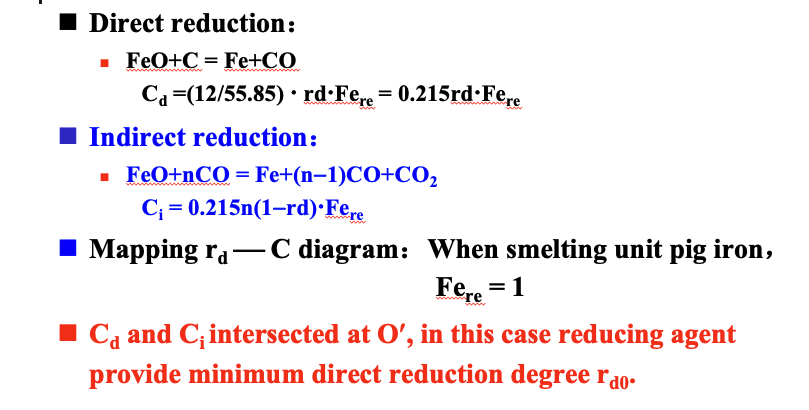

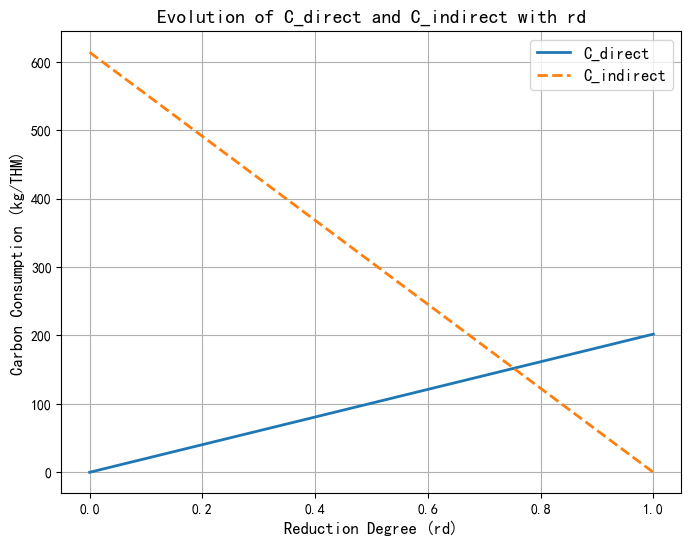

In [12]:
# The excess ration of indirect reduction is n=3.04 at 900℃

n=3.04

def C_direct(rd):
    
    return 12/56*df_hot_metal_comp_with_totals["Year Ave"].loc["Fe"]*10*rd

def C_indirect(rd):
    
    return 12/56*n*df_hot_metal_comp_with_totals["Year Ave"].loc["Fe"]*10*(1-rd)

import matplotlib.pyplot as plt
import numpy as np

# Generate a range of rd values from 0 to 1
rd_values = np.linspace(0, 1, 100)

# Calculate C_direct and C_indirect for each rd value
C_direct_values = [C_direct(rd) for rd in rd_values]
C_indirect_values = [C_indirect(rd) for rd in rd_values]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(rd_values, C_direct_values, label="C_direct", linewidth=2)
plt.plot(rd_values, C_indirect_values, label="C_indirect", linewidth=2, linestyle='--')
plt.xlabel("Reduction Degree (rd)", fontsize=12)
plt.ylabel("Carbon Consumption (kg/THM)", fontsize=12)
plt.title("Evolution of C_direct and C_indirect with rd", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## 2.2 Calculate the carbon consumption due to energy requirement

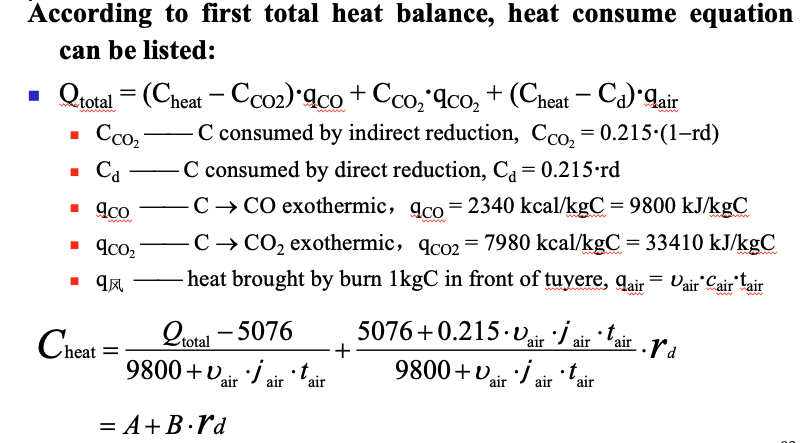

In [13]:
Df_Carbon=pd.DataFrame()

Df_Carbon["TotalInput"] = [df_C["Total Carbon Consumption, kg/tHM"].loc["Year Ave"]]
Df_Carbon["HMDissolution"]= df_C["HM carbon"].loc["Year Ave"]
Df_Carbon["EstimatedDustCarbon"]= 0 #  6.0

Df_Carbon["GasifiedCarbon"]= Df_Carbon["TotalInput"]-Df_Carbon["HMDissolution"]-Df_Carbon["EstimatedDustCarbon"]

print(Df_Carbon)

   TotalInput  HMDissolution  EstimatedDustCarbon  GasifiedCarbon
0  443.780069        47.8971                    0      395.882969


In [14]:
TopGas={
    "CH4":0,
    "CO2":20   ,
    "CO":20
}

Vol_Gasification=Df_Carbon["GasifiedCarbon"]/(TopGas["CH4"]+TopGas["CO2"]+TopGas["CO"])*100*22.4/12

# m3/tHM
Vol_Gasification=Vol_Gasification[0]
Vol_Gasification

1847.453853428372

In [15]:
# There is not N2 detector for the top gas composition analysis
# The burden might also carry some N2 to the top gas and it is estimated to be 3 kg N2 /tHM 
TopGas["N2"]=100-(TopGas["CH4"]+TopGas["CO2"]+TopGas["CO"])-2.41
TopGas

# m3/tHM
Vol_Blast=1/0.79*(Vol_Gasification*TopGas["N2"]/100-0.8*3)
Vol_Blast

Vol_Blast_Moisture=Vol_Blast*0.01 #m3/tHM
Vol_Blast_with_Moisture=Vol_Blast+Vol_Blast_Moisture
Vol_Blast_with_Moisture

# Assuming the utilization ratio of H2 is equal to that of CO
# The resouce of H2 is from raw materials
TopGas["H2"]=2.41
H2_Consumption_in_reduction=Vol_Gasification*TopGas["H2"]/100*0.4/0.6

In [16]:
# Energy balance
# 1. The combustion of tuyere carbon
Qc=9800* df_C["Tuyere Conbust"].loc["Year Ave"] # kJ/tHM
print(Qc)

# 2. Oxidation of C, CO, H2
Qco=9800*(46.77+6.37+1.6) #kJ/tHM
Qco2=12650*318.76 #kJ/tHM
QH2O=10800*29.67 #kJ/tHM

# 3. Carried by hot blast
Qblast=Vol_Blast_with_Moisture*1.424*1167 #kJ/mol
Qtotal=Qc+Qco+Qco2+QH2O+Qblast
Qtotal #kJ/tHM

# remove the heat for pyrolysis
Qcoalpyro=df_fuel["Year Ave"].loc["Coal"]*1000 #kJ/tHM
Qmoisture=10800*13.2

Qpyro=Qcoalpyro+Qmoisture
Qpyro

Qtotal_net=Qtotal-Qpyro
print("Qtotal_net:",Qtotal_net)

3008751.7829202986
Qtotal_net: 9869149.453741705


In [17]:
Blast_oxygen=0.983*(0.21+0.29*0.01)+0.017*0.999
vblast=0.9333/Blast_oxygen # m3/kgC

vblast

tblast=1167 # ℃
Cblast=1.424 # kJ/m3
qblast=vblast*Cblast*tblast # kJ/kgC
print("qblast:",qblast)

Qtotal_net_1kgFe=Qtotal_net/(df_hot_metal_comp_with_totals["Year Ave"].loc["Fe"]*10)
print("Qtotal_net_1kgFe:",Qtotal_net_1kgFe)

A=(Qtotal_net_1kgFe-5076)/(9800+qblast)

B=(5076+0.215*qblast)/(9800+qblast)

print("A, B:",A, B)

qblast: 6854.68065093959
Qtotal_net_1kgFe: 10468.99235564217
A, B: 0.3238124145801571 0.3932682035294685


Intersection Point: Reduction Degree (rd) = 0.242, Carbon Consumption (kg/THM) = 465.230
468.0290000000001


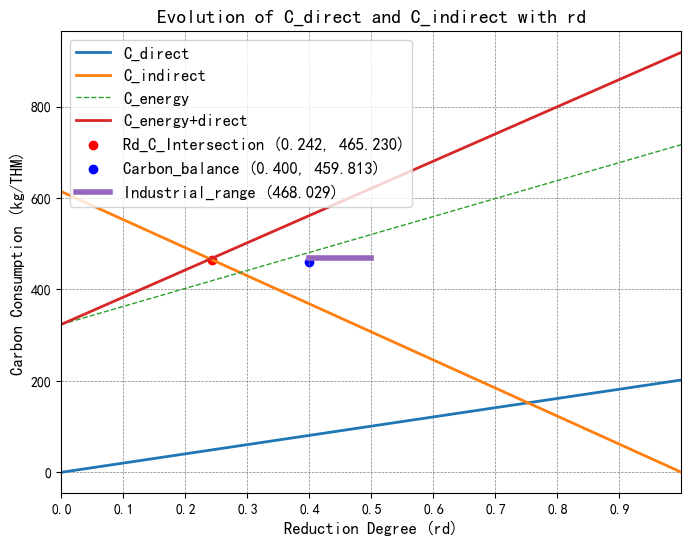

In [18]:
def C_energy(rd):
    return (A+B*rd)*1000


# Calculate values and convert them to NumPy arrays
C_direct_values = np.array([C_direct(rd) for rd in rd_values])
C_indirect_values = np.array([C_indirect(rd) for rd in rd_values])
C_energy_values = np.array([C_energy(rd) for rd in rd_values])
C_energy_direct_values = C_energy_values + C_direct_values

# Find the intersection point between C_indirect and C_energy_direct
difference = np.abs(C_indirect_values - C_energy_direct_values)
intersection_index = np.argmin(difference)  # Index of closest match

# Intersection coordinates
intersection_rd = rd_values[intersection_index]
intersection_C = C_indirect_values[intersection_index]

print(f"Intersection Point: Reduction Degree (rd) = {intersection_rd:.3f}, Carbon Consumption (kg/THM) = {intersection_C:.3f}")

#Result calculated by carbon balance
rd_set=data_rd["Year Ave"][0]
C_cal=df_C["Total Carbon Consumption, kg/tHM"][0]

#Industrial Results
C_indus=df_fuel["Year Ave"].loc["Total Fuel"]*df_C_content_in_all_full["Fixed Carbon Content (%)"].loc["Year Ave"]/100
print(C_indus)

# Generate a range of rd values from 0 to 1
rd_indus = np.linspace(0.4, 0.5, 10)
C_indus_values = np.array([C_indus for rd in rd_indus])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(rd_values, C_direct_values, label="C_direct", linewidth=2)
plt.plot(rd_values, C_indirect_values, label="C_indirect", linewidth=2)
plt.plot(rd_values, C_energy_values, label="C_energy", linewidth=1, linestyle='--')
plt.plot(rd_values, C_energy_direct_values, label="C_energy+direct", linewidth=2)
plt.scatter(intersection_rd, intersection_C, color='red', label=f"Rd_C_Intersection ({intersection_rd:.3f}, {intersection_C:.3f})")
plt.scatter(rd_set, C_cal, color='blue', label=f"Carbon_balance ({rd_set:.3f}, {C_cal:.3f})")
plt.plot(rd_indus, C_indus_values,label=f"Industrial_range ({C_indus:.3f})", linewidth=4)
plt.xlabel("Reduction Degree (rd)", fontsize=12)
plt.ylabel("Carbon Consumption (kg/THM)", fontsize=12)
plt.title("Evolution of C_direct and C_indirect with rd", fontsize=14)
plt.legend(fontsize=12)
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, 0.1))  # Set x-axis ticks every 1 unit
plt.grid(True)
# Customize the grid (optional)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()